# Human Protein Atlas Image Classification


Image classification of microscope slides based on mixed protein patterns.

### Project Description

The objective for this project is to determine the locations of protein organelles present in the microscope images. This breaks down into two parts: first, identifying the protein location (in general) from the image, and second, labelling each organelle within the protein.

In particular we aim to build a model that can reliably make predictions even when the images contain a mixture of different cell types with different morphologies. 

### Task 

The problem is a multi-label image classification task. Each image will contain a mixture of different cell types there are 28 in total. Therefore, the CNN must be able to predict for each image one or many of the 28 labels. 

The training images that was provided by the kaggle competition includes a train_csv file that contains a list of image ids with the identified protein labels. 


### Requirements

- keras
- tensorflow
- numpy
- pydot
- pandas
- OpenCV (opencv-python)

In [1]:
# libraries

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Input, Flatten, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras import backend

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import cv2                      # openCV image processing
import pickle                   # object serialization
import numpy as np              # linear algebra
import pandas as pd             # data processing
import pydot                    # graphing/visualization
import matplotlib.pyplot as plt # graphing/visualization

import os
import gc
import random
import csv
import sys

Using TensorFlow backend.


### Labels
All of the 28 labels for identifying the protien. We are predicting protein organelle localization labels for each sample. The dataset was acquired in a standardized way using one imaging modality (confocal microscopy). All image samples are represented by four filters (stored as individual files), the protein of interest (green) plus three cellular landmarks: nucleus (blue), microtubules (red), endoplasmic reticulum (yellow). The green filter should hence be used to predict the label, and the other filters are used as references.

In [2]:
NUCLEOPLASM                   = 0
NUCLEAR_MEMBRANE              = 1
NUCLEOLI                      = 2
NUCLEOLI_FIBRILLAR_CENTER     = 3
NUCLEAR_SPECKLES              = 4
NUCLEAR_BODIES                = 5
ENDOPLASMIC_RETICULUM         = 6
GOLGI_APPARATUS               = 7
PEROXISOMES                   = 8
ENDOSOMES                     = 9
LYSOSOMES                     = 10
INTERMEDIATE_FILAMENTS        = 11
ACTIN_FILAMENTS               = 12
FOCAL_ADHESION_SITES          = 13
MICROTUBULES                  = 14
MICROTUBULE_ENDS              = 15
CYTOKINETIC_BRIDGE            = 16
MITOTIC_SPINDLE               = 17
MICROTUBULE_ORGANIZING_CENTER = 18
CENTROSOME                    = 19
LIPID_DROPLETS                = 20
PLASMA_MEMBRANE               = 21
CELL_JUNCTIONS                = 22
MITOCHONDRIA                  = 23
AGGRESOME                     = 24
CYTOSOL                       = 25
CYTOPLASMIC_BODIES            = 26
RODS_AND_RINGS                = 27

### Some Constants
Here we define some constants that will define: the local datapath of the training, testing, and label data. We will also define some fundamental inputs to our model, such as: the number of epochs, learning rate, batch size, and the size of the subset we wish to train our data on. As we are constrained by our hardware, we will use a subset of the training data. Finally, we define a random.seed so we maintain the random numbers chosen.

In [3]:
LABELS_DIR = 'dataset'
TRAIN_DIR = 'dataset/train'
TEST_DIR = 'dataset/test'
TRAIN_SUBSET_SIZE = 50 # Selection of images to train from (chosen at random, max size is 31072)
LEN_LABELS = 28

EPOCHS = 5 # epochs to train for (the more the better)
INIT_LR = 1e-2 # initial learning rate for the solver
BS = 1 # batch size
IMG_SIZE = (512, 512, 1) # 512 by 512 pixels and only one channel (black and white)

# random seed
random.seed(56732)

### Image Loading

The first step is to take our dataset and prepare it so that it's ready for our model.

Images are split into four filters/layers:
- **green**: the protein of interest
- **blue**: the nucleus
- **red**: the microtubules
- **yellow**: the endoplasmic reticulum

For this project we will mostly be interested in the **green** filter, which will be used to predict the label, while the other filters will be used as references.

In [4]:
# Get images by layer

# training set images
train_green  = [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR) if 'green'  in i]

# Select TRAIN_SUBSET_SIZE images from the training set at random
random.shuffle(train_green)
train_green = train_green[:TRAIN_SUBSET_SIZE]
train_green_ids = [i[:-10].replace((TRAIN_DIR+'/'),'') 
                       for i in train_green] # remove '_green.png' and '_green.tif'

# Retrieve the other three layers for our subset (NB: unsorted)
train_blue =   [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-9] in train_green_ids) and ('blue' in i))]
train_red =    [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-8] in train_green_ids) and ('red' in i))]
train_yellow = [(TRAIN_DIR+'/{}').format(i) for i in os.listdir(TRAIN_DIR)
                  if ((i[:-11] in train_green_ids) and ('yellow' in i))]

# force garbage collection to make sure memory isn't wasted
gc.collect()

# test set images
test_green  = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'green'  in i]
test_blue   = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'blue'   in i]
test_red    = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'red'    in i]
test_yellow = [(TEST_DIR+'/{}').format(i) for i in os.listdir(TEST_DIR) if 'yellow' in i]

In [5]:
# Testing the above by seeing if the IDs are the same

train_green.sort()
train_blue.sort()
train_red.sort()
train_yellow.sort()
#print(train_green, end='\n\n')
#print(train_blue, end='\n\n')
#print(train_red, end='\n\n')
#print(train_yellow, end='\n\n')

### Label Loading

Loading the labels from *train.csv*. Here we seek to obtain all the labels for the train and test data. These labels could be multi-label, as in indicating more then one protein may be present in any data sample.

In [6]:
train_labels = {} # dictionary with key = photo ID and entry = list of labels

# Get all the labels
with open('dataset/train.csv') as label_file:
    csvreader = csv.reader(label_file, delimiter=',', quotechar='|')
    for row in csvreader:
        if "Id" not in row[0]:
            # only take the ones that were taken in the Image Loading part
            if any(row[0] in x for x in train_green):
                train_labels[row[0]] = row[1:][0].split(' ') # labels are separated by spaces

### Image Preprocessing
We now move onto some image preprocessing after reading the data image .csv files into lists. We will now define a function to produce the input labels and output labels in a unique vector style called one hot encoding. We will also load all the training data into a pandas.dataframe with their labels. 

#### One Hot Encoding
One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.The categorical value represents the numerical value of the entry in the dataset. For example, if a training example is labelled as having NUCLEOLI_FIBRILLAR_CENTER (=3) and ENDOPLASMIC_RETICULUM  (=6), the one_hot_encoded label would be: [0 0 0 1 0 0 1 0....(28 places in total)].

In [7]:
def one_hot_encode(train_tags):
    ''' Creates a one hot encoded dictionary of all labels for each pic'''
    encoded = dict()
  
    for key in train_tags.keys():
        # create empty vector
        encoding = np.zeros(LEN_LABELS, dtype='uint8')
        # mark 1 for each tag in the vector
        for tag in train_tags[key]:
            encoding[int(tag)] = 1
            
        encoded[key] = tuple(encoding)
  
    return encoded

#### Load into Pandas
We now load every data example, and its corresponding one-hot encoded label into a pandas.dataframe for easier reference later when recalling the label as an answer. We model the training set in this way when providing answers for training the model and testing the validation of the model.

In [8]:
ohe_labels = one_hot_encode(train_labels)
training_set = pd.DataFrame.from_dict(ohe_labels, orient='index')
training_set.index.name = "Photo ID"
training_set.reset_index()
training_set.head(n=1000)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Photo ID,,,,,,,,,,,,,,,,,,,,,
09599842-bbc7-11e8-b2bc-ac1f6b6435d0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17c12330-bbc9-11e8-b2bc-ac1f6b6435d0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1a7de584-bbad-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1ec3408c-bbb5-11e8-b2ba-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1edd9a1e-bbb4-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2664d9c8-bba5-11e8-b2ba-ac1f6b6435d0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
27e40a9e-bba0-11e8-b2b9-ac1f6b6435d0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
28bae982-bbc9-11e8-b2bc-ac1f6b6435d0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29c2151e-bbb8-11e8-b2ba-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Features Visualization (using matplotlib)

As we can see the training set is highly imbalanced.
This may be indicative of the rarity of certain protein types.

Data imbalance is a well-known problem in Machine Learning. Where some classes in the dataset are more frequent than others, and the neural net just learns to predict the frequent classes.

This is a big issue, to mitigate in this case, we can easily balance the data using sampling techniques.
By removing some frequent examples(downsampling)
By creating more in-frequent examples(upsampling) using image augmentation or any other method.

Perhaps a larger data set will show more balanced results!

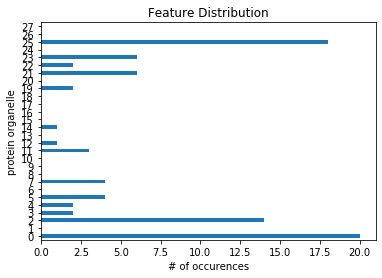

In [9]:
plt.figure()
plt.title("Feature Distribution")
plt.xlabel("# of occurences")
plt.ylabel("protein organelle")
# If this gives a boring graph, increase the subset size to look at more features.
training_set.astype(bool).sum(axis=0).plot(kind='barh')

#### Data Preprocessing

(see https://keras.io/preprocessing/image/)

This will provide real-time data augmentation later.

In [10]:
# construct the image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
              height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
              horizontal_flip=True, fill_mode="nearest")

#### Read and Process (into Keras-ready train and test sets)

In [11]:
# Based on Keras and OpenCV docs

def read_and_process(images_paths, ohe_dataframe):
    '''
    takes a panda dataframe with rows as picture IDs and columns as labels
    returns lists for keras (to be used as x and y inputs to the CNN)
    '''

    images = [] # will be used by keras as x
    labels = [] # will be used by keras as y

    for img in images_paths:
        # build image list using img_to_array() and OpenCV
        images.append(img_to_array(cv2.imread(img, cv2.IMREAD_GRAYSCALE))) # load images using cv2.imread()

        # build labels/target/tag list
        # Check labels at each step and build labels list accordingly
        # --> order is important, the lists are meant to be zip()ed
        for idx, row in ohe_dataframe.iterrows():
            if idx in img:
                labels.append(tuple(row))
    
    return np.array(images), np.array(labels)

### Test and Train splitting

Split the data from the train set into 80% training and 20% validation set.

In [12]:
# WIP
# USE sklearn.model_selection import train_test_split FOR THIS PART
X, Y = read_and_process(train_green, training_set)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=1)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(40, 512, 512, 1) (40, 28) (10, 512, 512, 1) (10, 28)


In [13]:
# train_x, train_y = read_and_process(train_green, training_set)
# test_x,  test_y  = read_and_process(validation_green, training_set)

### CNN Setup

Now that the preprocessing is out of the way, we can build our CNN structure.

This will be a smaller implementation of *VGGNet*, as described here: https://arxiv.org/pdf/1409.1556/

#### Input Layer Setup


In [14]:
model = Sequential()
height, width, depth = IMG_SIZE
input_shape = (height, width, depth) # derived from image size
chanDim = -1
classes = LEN_LABELS # number of classification classes

# if we are using "channels first", update the input shape
# and channels dimension
if backend.image_data_format() == "channels_first":
    input_shape = (depth, height, width)
    chanDim = 1

#### Conv + ReLU + Pool Blocks

Increasing filter sizes help increase depth.

In [15]:
# First CONV => RELU => POOL block
model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape)) # 32 filters and a 3x3 kernel
model.add(Activation("relu")) # standard activation layer
model.add(BatchNormalization(axis=chanDim)) # normalize all inputs to the [0, 1] range
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25)) # dropout will reduce overfitting by randomly dropping 25% of node connections

# (CONV => RELU) * 2 => POOL (first double convolution before pooling)
model.add(Conv2D(64, (3, 3), padding="same")) # 64 filters and 3x3 kernel
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2))) # smaller pool size this time to reduce spatial size
model.add(Dropout(0.25))
 
# (CONV => RELU) * 2 => POOL (second double convolution before pooling)
model.add(Conv2D(128, (3, 3), padding="same")) # 128 filters and 3x3 kernel
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#### Fully Connected + ReLU block

In [16]:
# first (and only) set of FC => RELU layers
model.add(Flatten()) # Collapses the spatial dimensions of the input into the channel dimensions
model.add(Dense(1024)) # dense layer of neurons with 1024 being the dimensionality of the output space
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5)) # Dropout of 50%

# Since this is multi-label classification we use the sigmoid activation function
model.add(Dense(classes)) # output dimensionality equal to the number of output classes
model.add(Activation("sigmoid"))

##I think we want "softmax" not sigmoid, any picture may be multiple 1's

#### Optimizer

In [17]:
# opt = SGD(lr=0.01, momentum=0.9) # Stochastic Gradient Descent with 0.01 learning rate
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS) # Adam will provide results faster than SGD with similar quality

#### FBeta Score , Precision, and Recall Functions

We must define our performance metrics before compiling the model.

In [18]:
# calculate fbeta score for multi-class/label classification
def fbeta(y_true, y_pred, beta=2):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    # calculate fbeta, averaged across each class
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score

# calculate precision
def precision(y_true, y_pred):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    # calculate precision
    p = tp / (tp + fp + backend.epsilon())
    
    return p

# calculate recall
def recall(y_true, y_pred):
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate recall
    r = tp / (tp + fn + backend.epsilon())
    
    return r


#### Model Compilation

In [19]:
# We use binary cross-entropy as this is multilabel multicategory classification
# For metrics we look at accuracy but also a more advanced metric for multilabel classification called the F-beta score
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', precision, recall, fbeta])

### Training

In [20]:
# train the network

# With data augmentation
#hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=BS),
#            validation_data=(testX, testY),
#            steps_per_epoch=(len(trainX) // BS),
#            epochs=EPOCHS, verbose=1)

# Without data augmentation
hist = model.fit(trainX, trainY,
                batch_size=BS,
                validation_data=(testX, testY),
                epochs=EPOCHS, verbose=1)

Train on 40 samples, validate on 10 samples
Epoch 1/5
40/40 [==============================] - 343s 9s/step - loss: 0.2812 - accuracy: 0.9339 - precision: 0.1000 - recall: 0.0417 - fbeta: 0.0470 - val_loss: 0.3010 - val_accuracy: 0.8571 - val_precision: 0.1493 - val_recall: 0.3333 - val_fbeta: 0.2287
Epoch 2/5
40/40 [==============================] - 332s 8s/step - loss: 0.1812 - accuracy: 0.9348 - precision: 0.0250 - recall: 0.0083 - fbeta: 0.0096 - val_loss: 0.2989 - val_accuracy: 0.9250 - val_precision: 0.3000 - val_recall: 0.2833 - val_fbeta: 0.2746
Epoch 3/5
40/40 [==============================] - 325s 8s/step - loss: 0.1789 - accuracy: 0.9357 - precision: 0.0500 - recall: 0.0188 - fbeta: 0.0212 - val_loss: 0.5364 - val_accuracy: 0.8964 - val_precision: 0.2500 - val_recall: 0.3333 - val_fbeta: 0.3024
Epoch 4/5
40/40 [==============================] - 345s 9s/step - loss: 0.1821 - accuracy: 0.9339 - precision: 0.0000e+00 - recall: 0.0000e+00 - fbeta: 0.0000e+00 - val_loss: 0.7980 

### Validation

#### Diagnostics Visualization

In [21]:
# WIP
def summarize_diagnostics(history):
    # plot loss 
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='test')
    #plot precision
    plt.subplot(213)
    plt.title('Precision')
    plt.plot(history.history['precision'], color='blue', label='train')
    plt.plot(history.history['val_precision'], color='orange', label='train')
    #plot recall
    plt.subplot(214)
    plt.title('Recall')
    plt.plot(history.history['recall'], color='blue', label='train')
    plt.plot(history.history['val_recall'], color='orange', label='train')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_plot.png')

ValueError: num must be 1 <= num <= 2, not 3

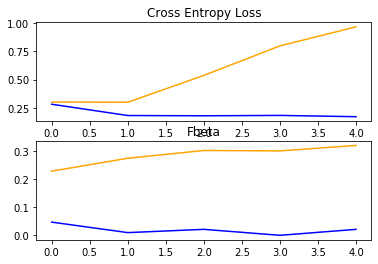

In [22]:
summarize_diagnostics(hist)
#precision = true positives / (true positives + false positives)
#recall = true positives / (true positives + false negatives)
#fbeta ==> generalized f1 score derived from both precision and recall averaged over all classes


### Model Serialization

In [ ]:
# WIP -- Optional
# Serialize the model using pickle (if possible) to avoid having to re-train it